In [1]:
%load_ext autoreload
%autoreload 2
%aimport -decode_fish.engine.place_psfs

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.plotting import *
from decode_fish.engine.noise import estimate_noise_scale
from decode_fish.engine.microscope import add_pos_noise
import shutil
from decode_fish.funcs.visualization import *
from decode_fish.funcs.predict import window_predict
from decode_fish.funcs.exp_specific import *
from decode_fish.funcs.matching import matching
import kornia

from omegaconf import open_dict
from hydra import compose, initialize

initialize(config_path="../config")

hydra.initialize()

In [3]:
# import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

# Training
Data taken from https://download.brainimagelibrary.org/cf/1c/cf1c1a431ef8d021/

In [ ]:
def README():
    # This data collection contains spatially resolved single-cell transcriptomics datasets acquired using MERFISH on the mouse primary motor cortex (MOp) collected by the Xiaowei Zhuang Lab at Harvard University and Howard Hughes Medical Institute.

    # * The dataset contains MERFISH images of 12 experiments, which include 64 coronal slices of the MOp region (10 um thick slices, every 100um interval) collected from 2 biological replicates. For each mouse, 6 experiments were performed, and each experiment was named with the mouse id plus the sample id, e.g. mouse1_sample1, mouse2_sample3. For each experiment, multiple coronal slices (4-6 slices) were included on the same coverslip and were imaged together.

    # * In this dataset, a total of 258 genes were imaged. Among the 258 genes, 242 genes were imaged using MERFISH, which encodes individual genes with error-robust barcodes (22-bit binary codes in this case), imprints the barcodes onto the RNAs using combinatorial labeling with encoding probes, and measures the barcodes bit-by-bit using sequential hybridization of readout probes. The 22 bits are imaged in 11 hybridization rounds with two-color imaging each round. The remaining 16 genes were imaged by 8 sequential rounds of two-color FISH.

    # * Each of the subdirectory folders contains either the raw (e.g. mouse1_sample1_raw) or processed images (e.g. mouse1_sample1_processed) of one experiment. Each experiment contains many fields of view (FOVs) and each tiff file in the folder corresponds to the images of one FOV. The raw image files are named as aligned_images plus the FOV id (e.g. aligned_images0.tif); the processed image files are named as processed_images plus the FOV id (e.g. processed_images100.tif).

    # â€¢	{sample_id}_raw: folders containing raw images. Each raw image file, corresponding to one FOV, is a stacked tiff file of multiple frames, each frame corresponding to one z-plane of one channel and each channel corresponding to one bit of the MERFISH imaging process, or one gene imaged in the sequential hybridization process, or the DAPI and polyT images used for cell segmentation. Seven z-planes are imaged for each channel. Images are aligned by fiducial bead fitting across each imaging round. The tiff stacks are ordered as channel 1 z-planes 1 through 7, channel 2 z-planes 1 through 7, â€¦, channel 40 z-plane 1 through 7. See data_organization_raw.csv file for detailed channel information.

    # â€¢	{sample_id}_processed: folders containing processed images. Each processed image file, corresponding to one FOV, is a stacked tiff file of multiple frames, each frame corresponding to one z-plane of one channel and each channel corresponding to one bit of the MERFISH imaging process, or the DAPI and polyT images used for cell segmentation. Seven z-planes are imaged for each channel. Images are aligned by fiducial bead fitting across each imaging round, and processed with a high pass filter and deconvolution. The tiff stacks are ordered the same as the raw images, except that images for the genes imaged by straight sequential hybridization are not included. See data_organization_processed.csv file for detailed channel information, and preprocessing.json file for parameters used in image processing. 
    # Note: For the 650 nm channels, a significant number of spots observed the first z-plane (i.e. at the coverslip surface) correspond to non-specific binding of the 650 nm dye to the coverslip surface, and the vast majority of these non-specific binding spots are decoded as invalid barcodes in the decoding process and are not used for subsequent analysis.  

    # * The processed_data folder contains the following files:
    # â€¢	segmented_cells_{sample_id}.csv: Segmented cell boundary coordinates of each z-plane and the slice id that each cell belongs to for each experiment. Note that each experiment includes 4-6 tissue slices on a single coverslip, and the slice id gives the slice number that the cells belong to.
    # â€¢	spots_{sample_id}.csv: Decoded spot location (x,y,z) in the unit of microns and their target gene identity for each experiment. The same coordinate system was used in segmented_cells_{sample_id}.csv and spots_{sample_id}.csv for each experiment, and hence the spots can be parsed into the segmented cells (and also the slices) according by comparison of their coordinates with the cell boundary locations.  
    # â€¢	counts.h5ad: Cell by gene matrix of the whole dataset. The counts are normalized by the volume of each cell.
    # â€¢	cell_labels.csv: Cluster label assignment for each cell.

    # We also provide these files that are associated to this dataset:
    # â€¢	genes_combinatorial.txt: List of target genes that are imaged in combinatorial imaging rounds.
    # â€¢	genes_sequential.txt: List of target genes that are imaged sequentially after the combinatorial imaging rounds.
    # â€¢	probes.fasta: Provides sequences all encoding probes used for hybridization.
    # â€¢	codebook.csv: Provides the barcodes that encode individual genes measured in the combinatorial imaging rounds.
    # â€¢	data_organization_raw.csv: Provides information on how individual channels and z-planes are ordered in the multi-frame tiff file for each field of view of raw images.
    # â€¢	data_organization_processed.csv: Provides information on how individual channels and z-planes are ordered in the multi-frame tiff file for each field of view of processed images.
    # â€¢	microscope.json: Provides parameters of the microscope that was used with pixel size and orientation of images.
    # â€¢	preprocessing.json: Provides values and filters used in generating the processed images.
    # â€¢	fov_positions folder: contains the txt files of field of view positions for individual samples, named by its sample id.
    
    return

Own Notes: z-bins given in data_organization_raw.csv: 0.,1.5,3.,4.5,6.,7.5,9.

Values in the the prediction files: 0., 1.38248848, 2.76497696, 4.14746544, 5.52995392, 6.9124424 , 8.29493088

1.4 um would correspond to 13 pixels in x-y

In [71]:
cfg = compose(config_name='train.yaml', overrides= ["+exp_type=merfish_MOp"])
cfg = OmegaConf.create(cfg)

Make dataset specific changes

In [72]:
cfg.output.project = 'MERFISH_MOp'
cfg.output.group='sweep_mop_36'
cfg.run_name ='MERFISH_mop_36'
# cfg.sub_name='scaled'

# Path to the recording you want to train the network on. Can also use a * expression to load multiple tiffs (e.g. path/*.tif)
cfg.data_path.image_path = cfg.base_dir + '/datasets/CodFish/MERFISH/MOp/mouse1_sample1_raw/aligned_scaled4_images150.tif'

# Average number of foci per simulated volume. If your data does not contain any foci set this to 0.
cfg.genm.foci.n_foci_avg = 0
# Lower and upper limit of emitters simulated per focus
cfg.genm.foci.n_mol_range: [5,40]

# Sets the intensity scale of the simulation. Should be adjusted to cover observed intensity values 
cfg.genm.prob_generator.low = 0.05
cfg.genm.prob_generator.high = 0.15

# Set to 'disabled' if you do not have a wandb account.
cfg.output.wandb_mode = 'online'

cfg.network._target_ = 'decode_fish.engine.model.UnetDecodeNoBn_2S'
cfg.network.f_maps = 384
cfg.network.depth = 2
cfg.training.bs = 10

cfg.genm.noise.theta = 1.
cfg.genm.exp_type.randomize_noise_range = [0.3, 3.]
cfg.genm.microscope.col_shifts_enabled = True

cfg.sim.roi_mask.percentile = 20
cfg.sim.random_crop.crop_sz = 56

cfg.sim.bg_estimation.smoothing.smoothing_filter_size = 9
cfg.sim.bg_estimation.type = 'smoothing'

cfg.genm.intensity_dist.int_conc = 3.
cfg.genm.intensity_dist.int_rate = 1.
cfg.genm.intensity_dist.int_loc = 1.

cfg.genm.microscope.scale = 5000
cfg.genm.phasing = 0.1

cfg.data_path.psf_path = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/figures/MF_psf2n.tif'
cfg.genm.microscope.norm = 'escort'

cfg.training.mic.par_grads.channel_facs = True
cfg.training.mic.par_grads.channel_shifts = True
cfg.training.mic.par_grads.theta_par = False
cfg.training.mic.par_grads.psf_vol = True
cfg.training.mic.par_grads.color_shifts = True
cfg.training.mic.par_grads.z_facs = False
cfg.training.mic.par_grads.sc_fac = True

cfg.output.log_interval = 600

cfg.genm.emitter_noise.rate_fac = 5.

cfg.genm.pos_noise.pos_noise_xy = 0.3
cfg.genm.pos_noise.pos_noise_z = 0.04

cfg.training.net.opt.lr = 3.5e-4

cfg.evaluation.code_stats.enabled = True
cfg.training.schedule = [10000, 3000, 5000, 2000, 5000, 2000, 5000, 2000, 10000]
cfg.training.num_iters = 44000
cfg.network.n_chrom_map_ch = 2

cfg.training.psf.sched.step_size = 2000
cfg.training.mic.mean_diff = True

cfg.training.psf.opt.lr = 0.0002
cfg.training.mic.opt.lr = 0.001
cfg.training.psf.l1_reg = 0.0

cfg.training.net.bl_loss_scale = .003

cfg.sim.bg_estimation.shuffle_ch = True

cfg.data_path.model_init  = None
# cfg.data_path.model_init  = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//models/fishcod/MERFISH_MOp/sweep_mop_35/image_path:scaled4_images150//checkpoint/'
# cfg.data_path.micro_init  = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//models/fishcod/MERFISH_MOp/sweep_mop_35/image_path:scaled4_images150//checkpoint/'
cfg.training.target_mean = True
cfg.network.is_2D = True

cfg.genm.exp_type.em_noise_inf = True
NAME = 'l1_fix'

In [73]:
fname = f'../config/experiment/{cfg.run_name}.yaml'
OmegaConf.save(cfg, fname)
prepend_line(fname, '# @package _global_')
cfg.run_name

'MERFISH_mop_36'

In [74]:
home_dir = os.getenv("HOME")
print(f'bsub -gpu "num=1" -q gpu_rtx -o {home_dir}/logs/ofish.log -e {home_dir}/logs/efish.log {home_dir}/anaconda3/envs/decode_fish_dev2/bin/python {home_dir}/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment={cfg.run_name} run_name={NAME}')

bsub -gpu "num=1" -q gpu_rtx -o /groups/turaga/home/speisera/logs/ofish.log -e /groups/turaga/home/speisera/logs/efish.log /groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/bin/python /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment=MERFISH_mop_36 run_name=l1_fix


Create the dataloader which samples random subsets from the recorded volumes and generates simulated data that we use for training.  
For visualization purposes it is often better to not sample foci as they distort the colorscale.

In [8]:
img_5d, decode_dl = get_dataloader(cfg)
micro = load_psf_noise_micro(cfg)

Crop size larger than volume in at least one dimension. Crop size changed to (1, 56, 56)


/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


7 volumes


/groups/turaga/home/speisera/Dropbox (mackelab)/Artur/WorkDB/deepstorm/decode_fish/decode_fish/engine/psf.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  psf_vol = torch.tensor(psf_vol, dtype=torch.float32).to(device)


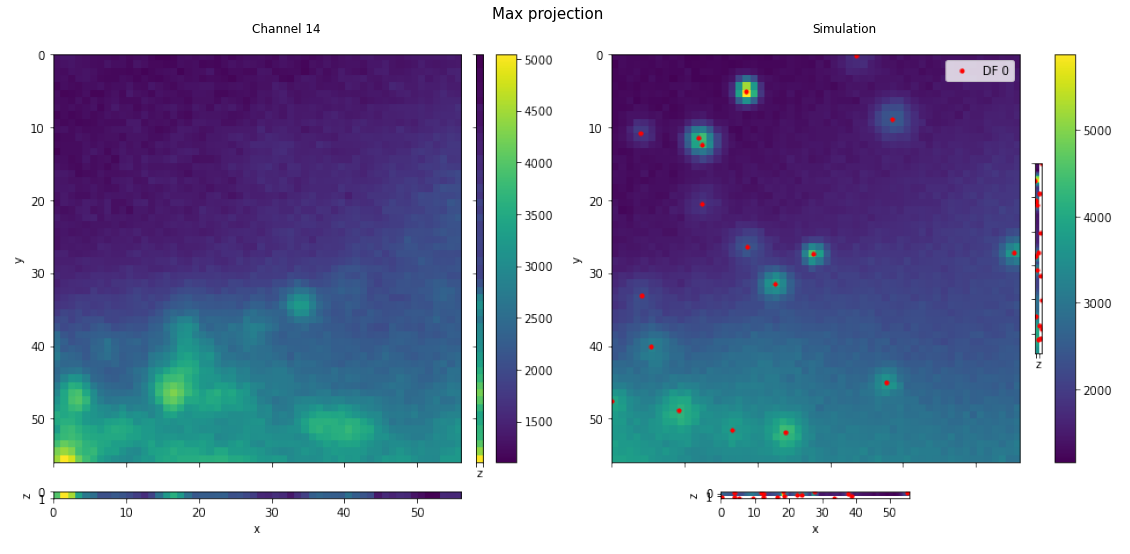

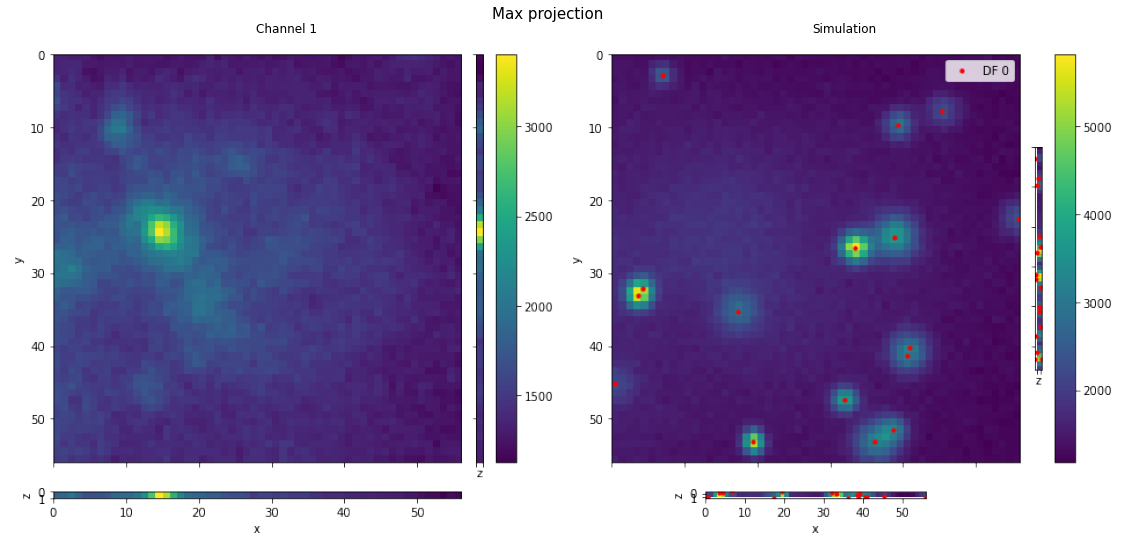

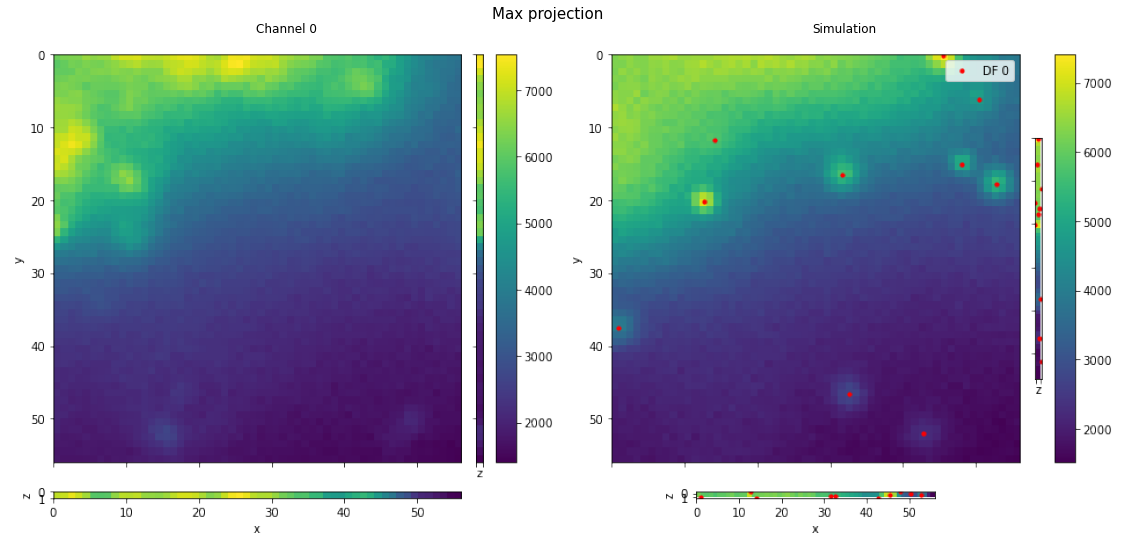

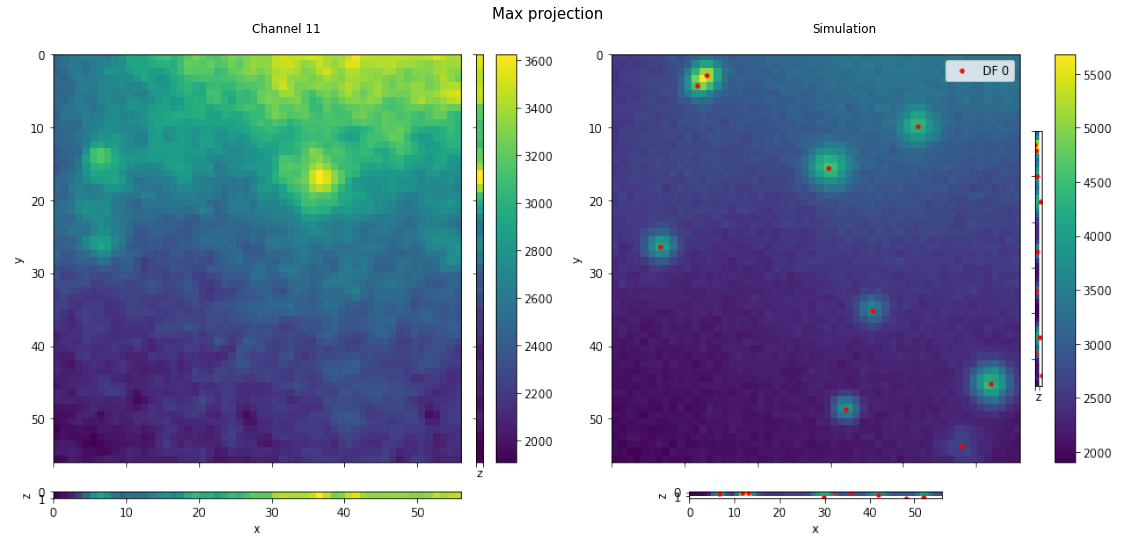

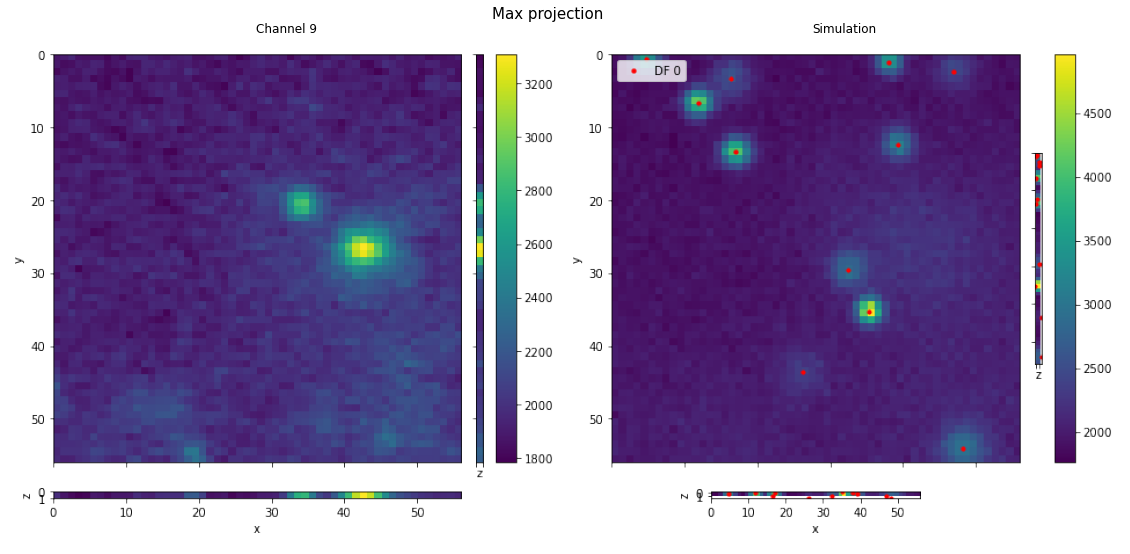

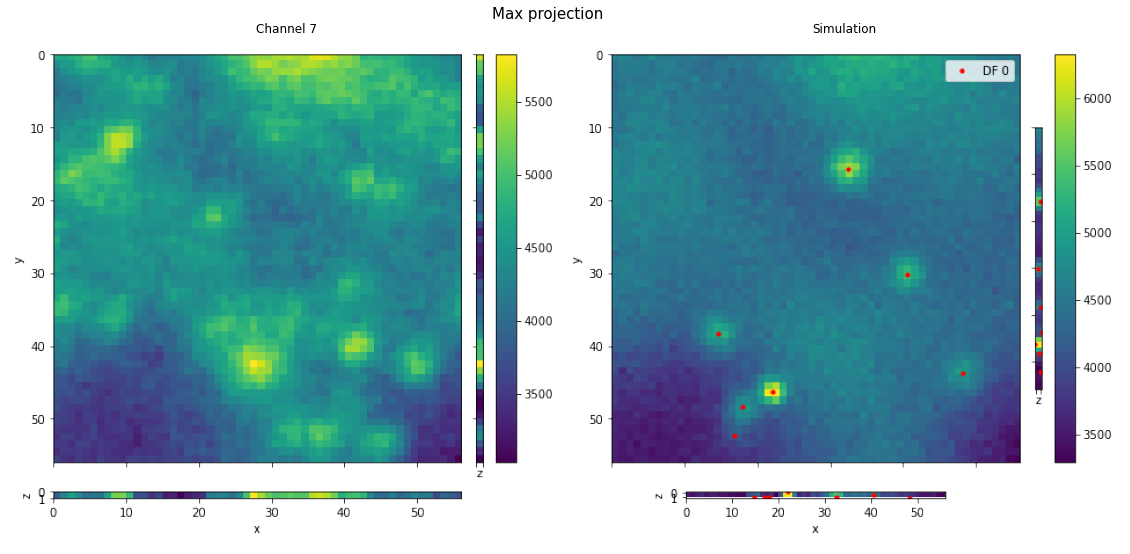

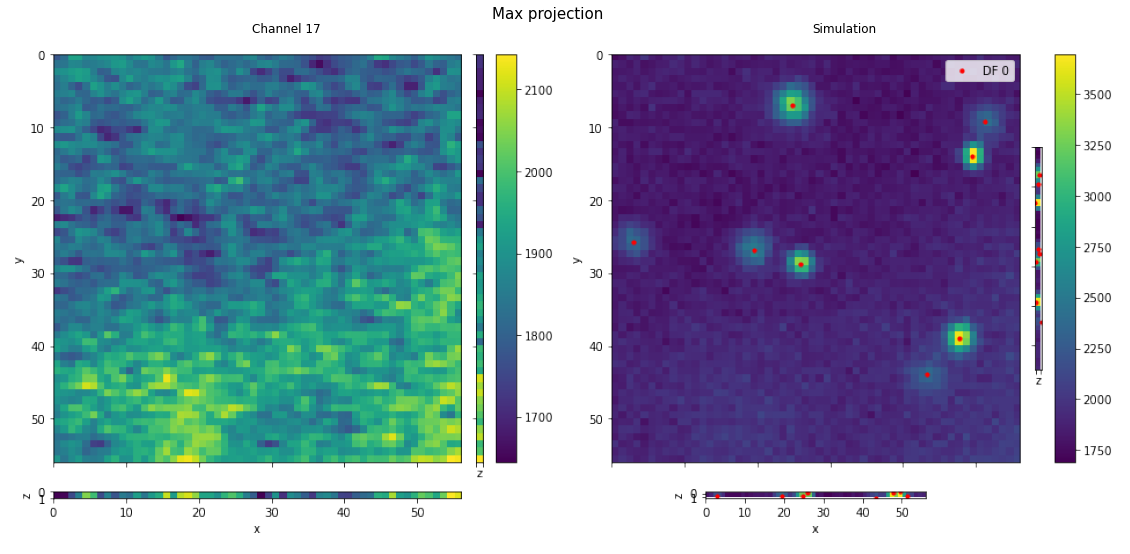

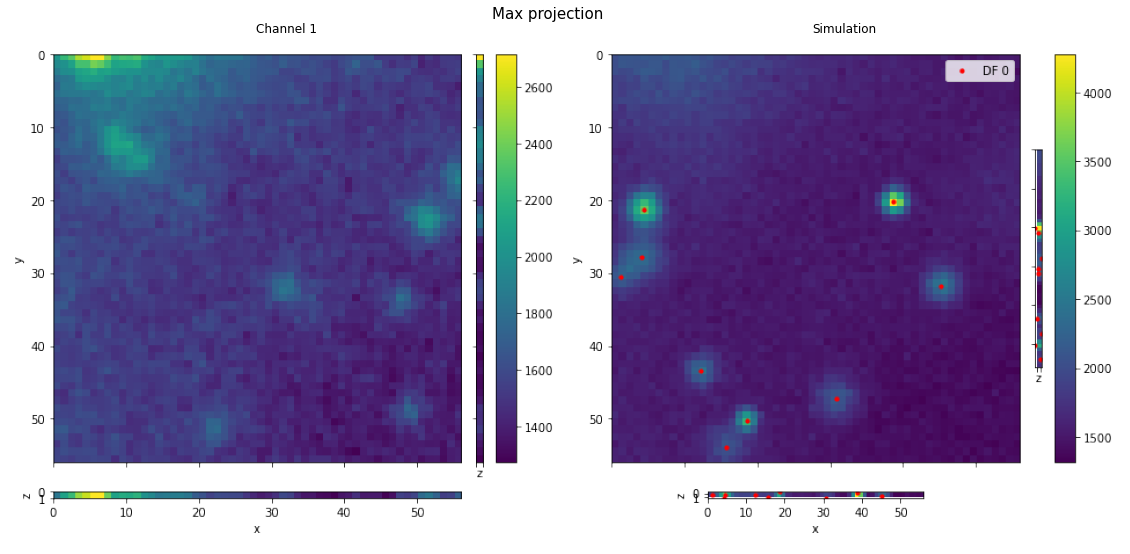

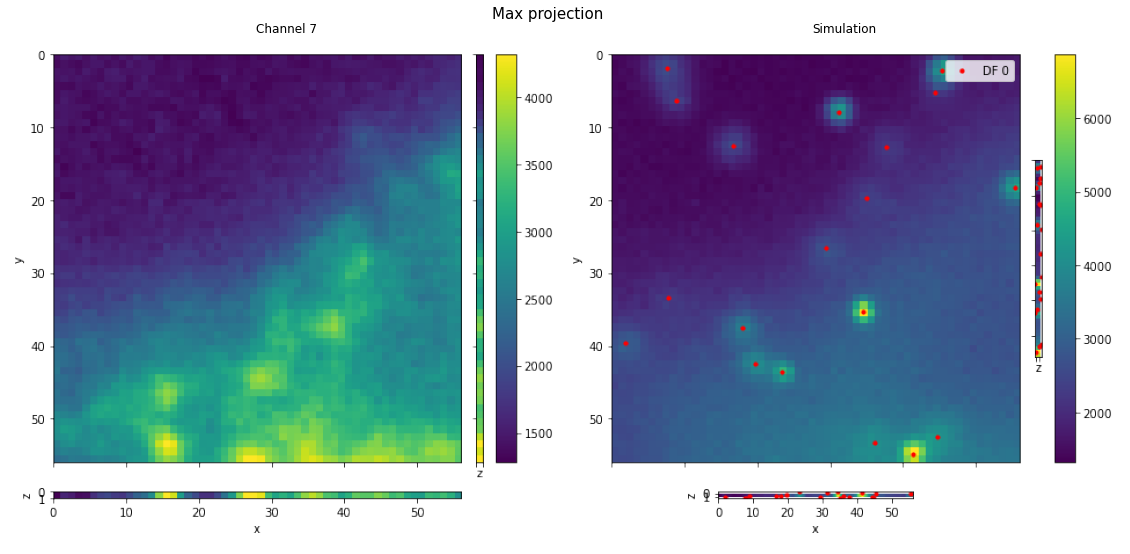

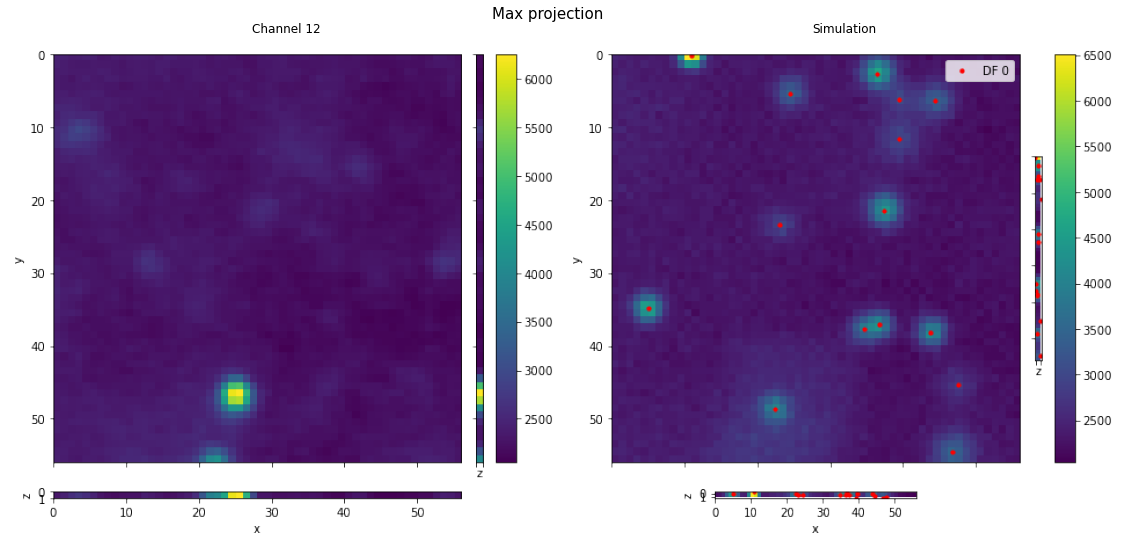

In [9]:
from decode_fish.engine.point_process import *
point_process = PointProcessUniform(**cfg.genm.intensity_dist, n_channels=cfg.genm.exp_type.n_channels, sim_z=True, slice_rec=True, codebook=None, int_option=1)
get_simulation_statistics(decode_dl, micro, point_process, int_threshold=0.1, samples=10)

# Evaluation

In [107]:
cfg1 = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_MOp/sweep_mop_35/image_path:scaled4_images151//train.yaml')

In [108]:
cfg2 = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_MOp/sweep_mop_36/aligned_scaled4_images151.tif//train.yaml')

In [104]:
codebook, targets = hydra.utils.instantiate(cfg.codebook)

In [105]:
# Load the model, post processing, imgages, dataloader
model, post_proc, micro, img_3d, decode_dl = load_all(cfg)
psf_vol = cpu(micro.psf.psf_volume)
psf_init = cpu(micro.psf_init_vol)
post_proc.codebook = torch.tensor(expand_codebook(torch.tensor(codebook)))

/groups/turaga/home/speisera/Dropbox (mackelab)/Artur/WorkDB/deepstorm/decode_fish/decode_fish/engine/psf.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  psf_vol = torch.tensor(psf_vol, dtype=torch.float32).to(device)


Crop size larger than volume in at least one dimension. Crop size changed to (1, 56, 56)
7 volumes


Parameter containing:
tensor([1.5108], device='cuda:0', requires_grad=True)


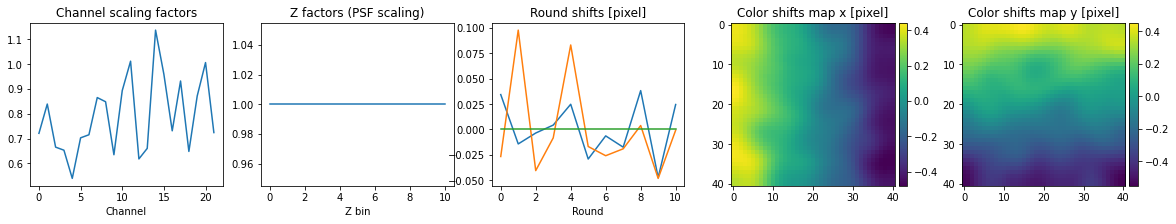

In [101]:
plot_micro_pars(micro, blur_cmap=True)
print(micro.sc_fac)

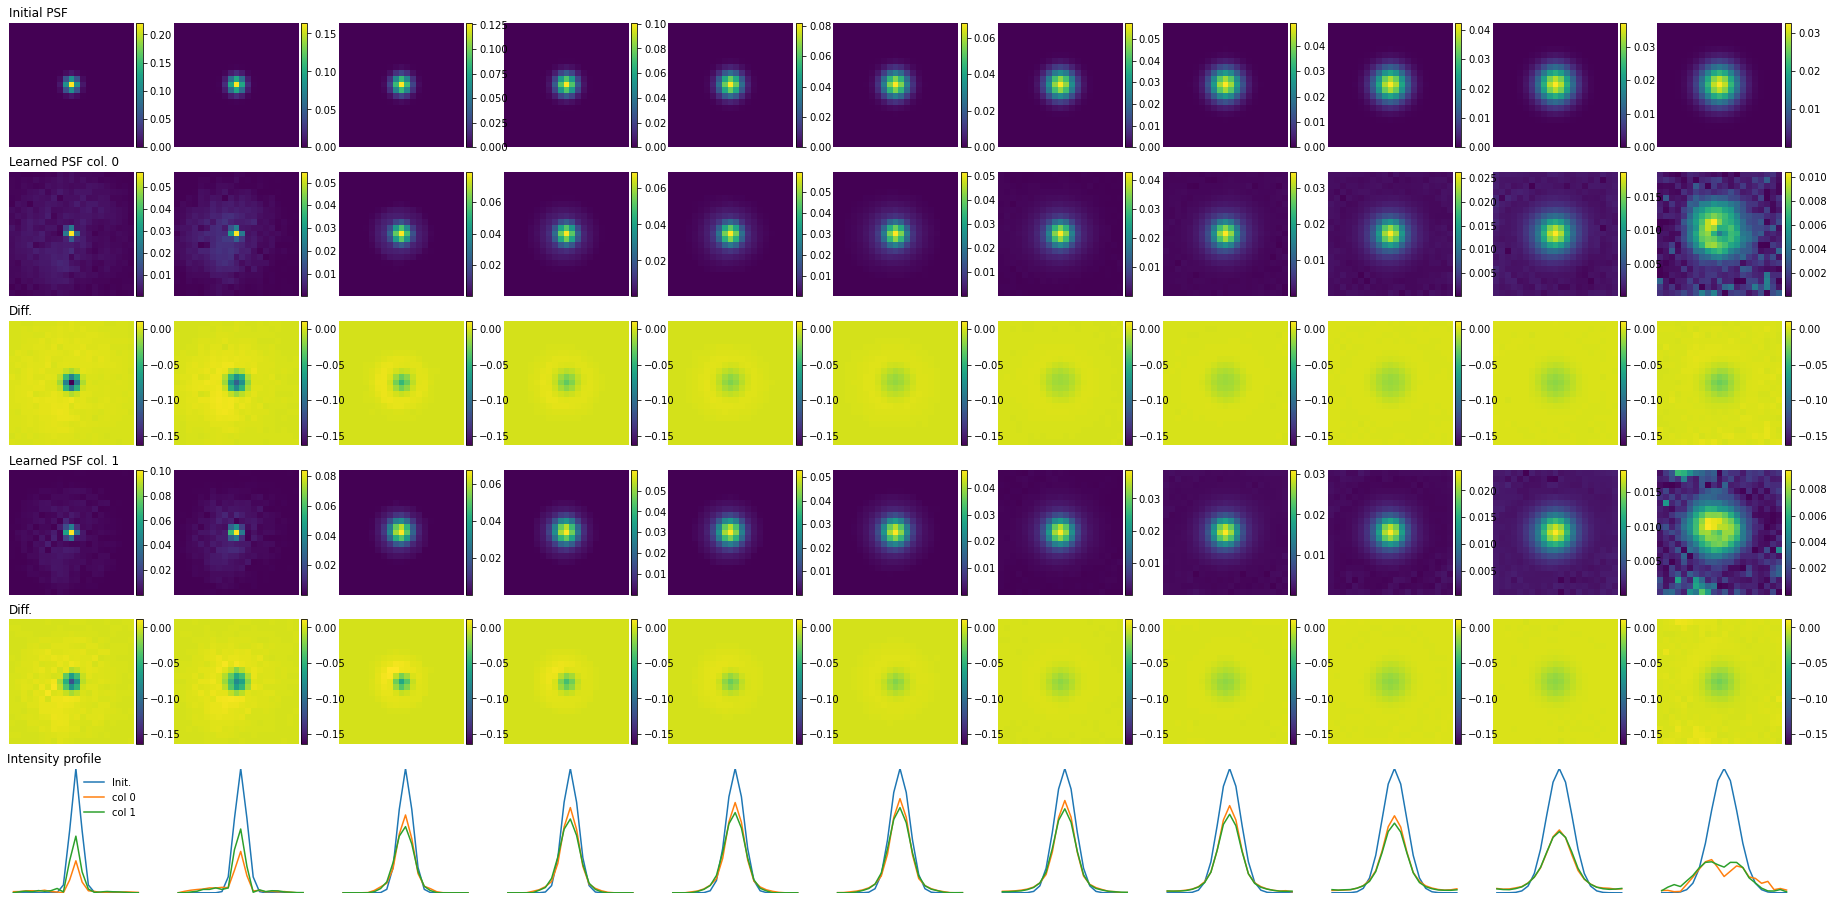

In [102]:
plot_slice_psf_pars(psf_vol, cpu(psf_init), normed=True)

Sample random sub volumes and overlay them with predictions,  also shows the residuals between the input volume and the reconstruction from applying the microscope and PSF model to those predictions. Sometimes it looks like the network if missing obvious molecules. Often times this is because they are at the very edge of the volume. In that case they will be localized once you process the whole volume.

10


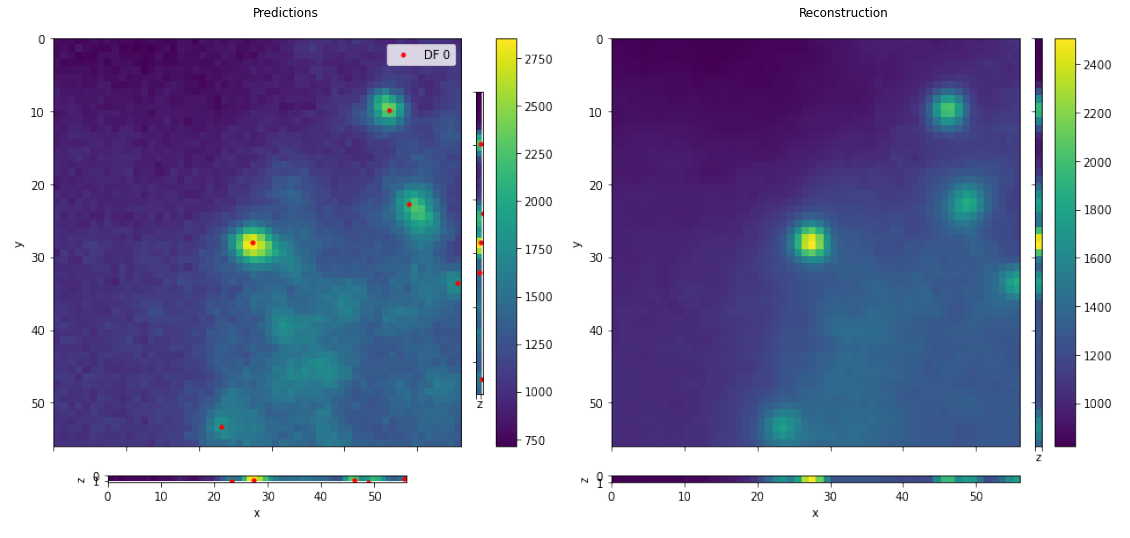

29


In [85]:
from decode_fish.funcs.visualization import *
x, local_rate, background, pred_df, rec, res_dict, psf_recs, psf_bgs, rois, ch_inp = eval_random_crop(decode_dl, model, post_proc, micro, plot='rec', crop_sz_xy=100, ret_preds=True, filt_rad=10)
print(len(pred_df))
# eval_random_crop(decode_dl, model, post_proc, micro, samples=10, plot='rec', crop_sz_xy=100, ret_preds=True)

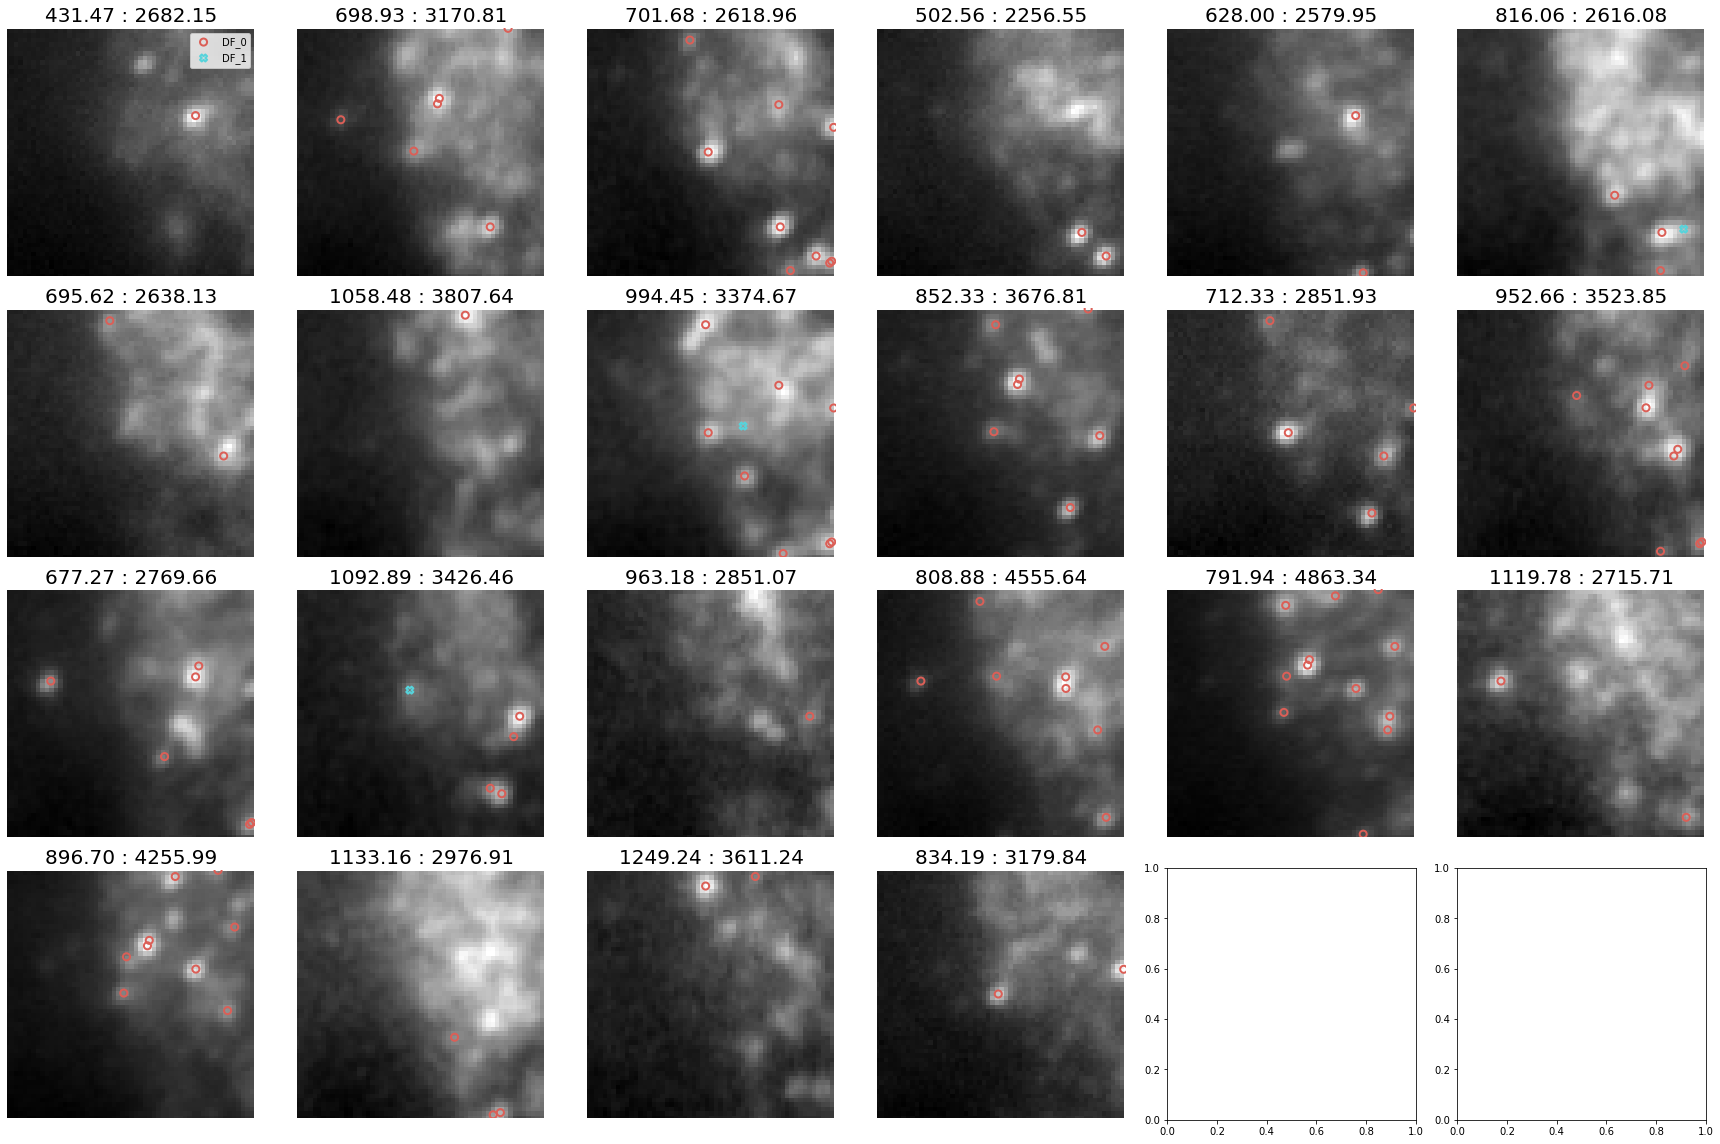

In [86]:
_ = plot_channels(x, dfs=[pred_df[pred_df['code_inds']<len(codebook)], pred_df[pred_df['code_inds']>len(codebook)]], n_rows=4, codebook=post_proc.codebook, sc_sz=50, size=4)

In [34]:
code_weight = torch.ones(len(post_proc.codebook))
code_weight[len(codebook):] *= cfg.genm.emitter_noise.rate_fac
point_process = PointProcessUniform(int_conc=cfg.genm.intensity_dist.int_conc, int_rate=cfg.genm.intensity_dist.int_rate, int_loc=cfg.genm.intensity_dist.int_loc, 
                                   sim_iters=5, n_channels=cfg.genm.exp_type.n_channels, sim_z=cfg.genm.exp_type.pred_z, slice_rec=cfg.genm.exp_type.slice_rec, 
                                   codebook=post_proc.codebook, int_option=cfg.training.int_option, code_weight=code_weight)

/groups/turaga/home/speisera/Dropbox (mackelab)/Artur/WorkDB/deepstorm/decode_fish/decode_fish/engine/point_process.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.codebook = torch.tensor(codebook).to(self.device) if codebook is not None else None


In [36]:
from decode_fish.funcs.routines import *
xsim, cols, gt = sim_data(decode_dl, micro, point_process, 50, n_codes=len(codebook), rate_fac=1.5, pos_noise_xy=cfg.genm.pos_noise.pos_noise_xy, pos_noise_z=cfg.genm.pos_noise.pos_noise_z)

In [37]:
pred_dfs = []
net_inp = torch.concat([xsim,cols], 1)
for i in range(len(net_inp)):
    pred_df = get_prediction(model, net_inp[i:i+1], post_proc, cuda=True)
    pred_dfs.append(pred_df)

pred_df = cat_emitter_dfs(pred_dfs)

In [38]:
perf, matches, _ = matching(px_to_nm(gt[gt['code_inds']>252], cfg.evaluation.px_size_zyx), pred_df[pred_df['code_inds']>252], tolerance=1000, print_res=True, match_genes=True, allow_multiple_matches=False)

Recall: 0.342
Precision: 0.930
Jaccard: 33.291
RMSE_vol: 138.309
Eff_3d: 3.914
FN: 44732.0 FP: 1757.0
Num. matches: 23200.000
Shift: 0.29,0.48,-6.20


In [39]:
perf, matches, _ = matching(px_to_nm(gt[gt['code_inds']<252], cfg.evaluation.px_size_zyx), pred_df[pred_df['code_inds']<252], tolerance=1000, print_res=True, match_genes=True, allow_multiple_matches=False)

Recall: 0.683
Precision: 0.948
Jaccard: 65.855
RMSE_vol: 50.973
Eff_3d: 57.392
FN: 51607.0 FP: 6153.0
Num. matches: 111402.000
Shift: 0.30,-0.25,1.42


If you are happy with the results you can run the network on whole volumes to get predictions. Be aware that a model will only produce good results on different recordings if the conditions with regards to PSF and intensity are similar as those used during training.

In [40]:
from decode_fish.funcs.exp_specific import read_MOp_tiff
img = read_MOp_tiff('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//datasets/CodFish/MERFISH/MOp/mouse1_sample1_raw/aligned_scaled4_images47.tif', z_to_batch=True)

In [41]:
from decode_fish.funcs.exp_specific import read_MOp_tiff
img = decode_dl.dataset.volumes
res_df = window_predict(model, post_proc, img, window_size=[None, 128, 128], crop=np.s_[:,:,:,:,:], device='cuda', chrom_map=get_color_shift_inp(micro.color_shifts, micro.col_shifts_yx)[:,:,None], scale=micro.get_ch_mult(), progress_bar=True)
print(len(res_df))

torch.Size([7, 22, 1, 2048, 2048])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [06:59<00:00, 59.91s/it]

188656


In [42]:
all_df = res_df.copy()
res_df = res_df[res_df['code_inds']<len(codebook)]
res_df.loc[:,'gene'] = targets[res_df['code_inds']]
res_df.loc[:,'class'] = res_df['gene'].str.contains('Blank')

0.05578906734690701


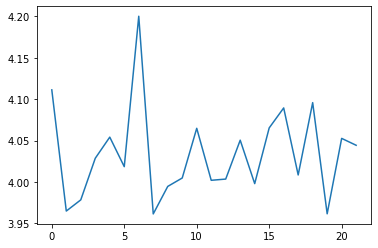

In [43]:
int_arr = zero_int_ch(res_df, codebook)[[f'int_{i}' for i in range(codebook.shape[1])]].values
ch_means = [int_arr[:,i].sum()/(int_arr[:,i] != 0).sum() for i in range(22)]
print(np.sqrt(np.var(ch_means)))
plt.plot(ch_means)

In [44]:
from decode_fish.funcs.merfish_eval import *
bench_df = get_mop_benchmark()
bench_df['class'] = bench_df['gene'].str.contains('Blank')
# bench_df, code_ref, targets = get_merfish_mop(return_bench_df=True)
bench_df = get_mop_fov(bench_df, 47)
bench_df = nm_to_px(bench_df, [1.085,1.085,1.085])
bench_df['x'] += 70
bench_df['y'] += 70

17130008


In [45]:
artifact_coords = pd.read_csv('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//datasets/CodFish/MERFISH/MOp/mouse1_sample1_raw/artifact_coords.csv')

In [47]:
res_sub = exclude_borders(res_df, border_size_zyx=[0,15000,15000], img_size=[2048*100,2048*100,2048*100])
bench_sub = exclude_borders(bench_df, border_size_zyx=[0,15000,15000], img_size=[2048*100,2048*100,2048*100])
res_sub = remove_fids(res_sub, px_to_nm(artifact_coords), tolerance=1000)
bench_sub = remove_fids(bench_sub, px_to_nm(artifact_coords), tolerance=1000)
print(len(bench_sub))
print(len(res_sub))

64252
98831


/groups/turaga/home/speisera/Dropbox (mackelab)/Artur/WorkDB/deepstorm/decode_fish/decode_fish/funcs/emitter_io.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_clean['frame_idx'] = frames[inds]
/groups/turaga/home/speisera/Dropbox (mackelab)/Artur/WorkDB/deepstorm/decode_fish/decode_fish/funcs/emitter_io.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_clean['frame_idx'] = frames[inds]


In [48]:
res_single = remove_doublets(res_sub, tolerance=300)
print(len(res_single)/len(res_sub))

0.9371148728637776


In [53]:
res_single = sel_int_ch(res_single, codebook)

64252 64252


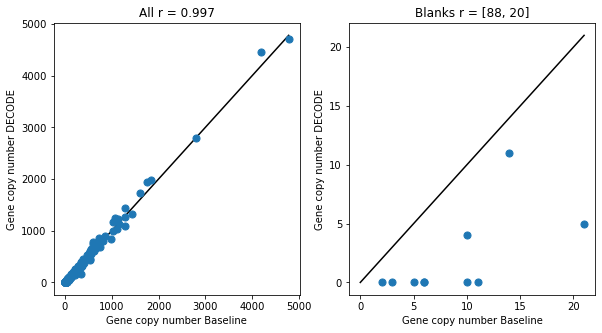

In [56]:
plot_gene_panels(res_single.nsmallest(64252 , 'int_ratio'), bench_sub, targets)

64252 76000


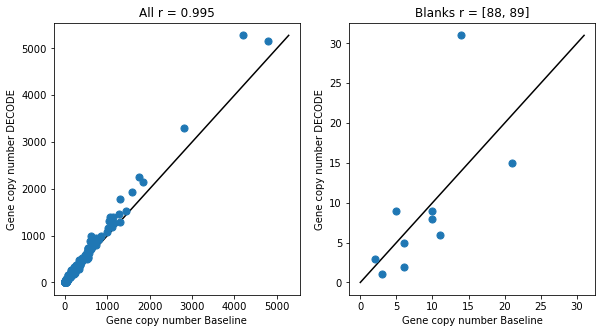

In [59]:
plot_gene_panels(res_single.nsmallest(76000 , 'int_ratio'), bench_sub, targets)

Text(0, 0.5, 'N Blanks')

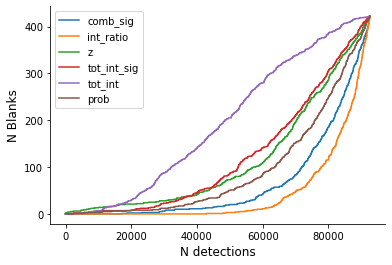

In [62]:
import seaborn as sns
for k in ['comb_sig','int_ratio','z','tot_int_sig','tot_int','prob']:
    ascending = True if k not in ['prob' , 'tot_int'] else False
    r  = make_roc(res_single, k, ascending=ascending)
    plt.plot(r, label=k)
plt.legend()
sns.despine()

plt.xlabel('N detections', size=12)
plt.ylabel('N Blanks', size=12)

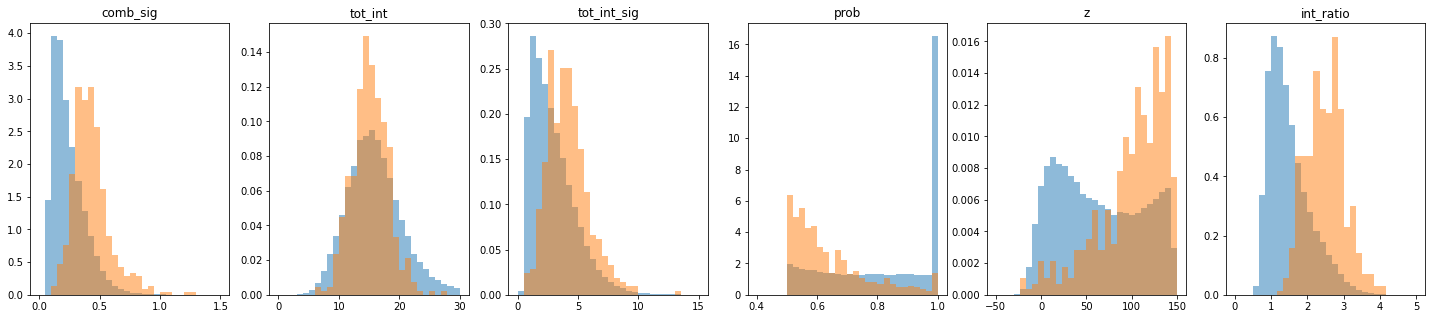

In [63]:
metrics = ['comb_sig','tot_int','tot_int_sig', 'prob','z','int_ratio']
bins = [np.linspace(0,1.5,31), np.linspace(0,30,31), np.linspace(0,15,31), np.linspace(0.4,1,31), np.linspace(-50,150.,31), np.linspace(0.,5., 31)]
plt.figure(figsize=(25,5))
for i in range(len(metrics)):
    plt.subplot(1,len(metrics),i+1)
    _=plt.hist(res_single[~res_single['gene'].str.contains('Blank')][metrics[i]], density=True, alpha=0.5, bins=bins[i], label='gene matches')
    _=plt.hist(res_single[res_single['gene'].str.contains('Blank')][metrics[i]], density=True, alpha=0.5, bins=bins[i], label='blank matches')
    plt.title(metrics[i])

In [64]:
for i in range(4):
    for j in range(i+1,4):
        print(i,j,np.corrcoef(res_single[f'int_{i}'], res_single[f'int_{j}'])[0,1])

0 1 0.46201192565354426
0 2 0.3972637710547642
0 3 0.36736753616942736
1 2 0.38147367298876406
1 3 0.3420939526862217
2 3 0.3434743654570607
